#Bài toán xác định và làm mở biển số xe ở Việt Nam.


*   Bộ môn: Máy học - CS114.M21.KHCL
*   Giảng viên:
    *   Lê Đình Duy
    *   Phạm Nguyễn Trường An
*   Thành viên nhóm:
    *   Đào Trần Anh Tuấn
    *   Lê Trần Hữu Phước
    *   Trần Phú Vinh
* Nguồn tham khảo:
    * facebookresearch/detectron2
    * roboflowteam







# Install Detectron2 Dependencies

In [1]:
#Liên kết google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Cài đặt packages cần thiết
# Cài đặt dependencies: (dùng cu101 vì colab sử dụng CUDA bản 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [ ]:
# Cài đặt detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

# Import and Register Custom Detectron2 Data

In [ ]:
#Lấy bộ dữ liệu đã chuẩn bị sẵn từ Roboflow 
!curl -L "https://app.roboflow.com/ds/KdOneQPUgT?key=MOJChnvGDG" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [6]:
# "Register" dữ liệu cho cả 3 tập train-val-test
from detectron2.data.datasets import register_coco_instances
register_coco_instances("dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")


WARNING [07/11 16:06:08 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/11 16:06:08 d2.data.datasets.coco]: Loaded 2385 images in COCO format from /content/train/_annotations.coco.json


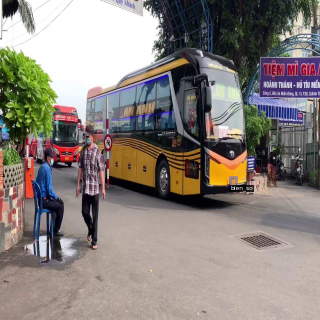

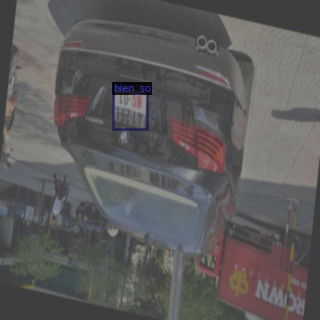

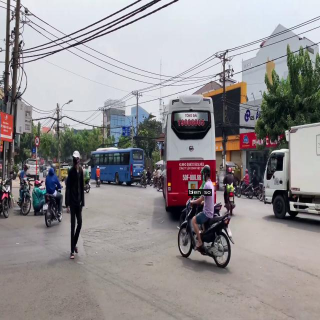

In [8]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("dataset_train")
dataset_dicts = DatasetCatalog.get("dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Train Custom Detectron2 Detector

In [9]:
#Set up các thư viện cần thiết để tiến hành train mô hình trên tập dữ liệu. 

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [10]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("dataset_train",)
cfg.DATASETS.TEST = ("dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 5900 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

# Use GPU to train
cfg.MODEL.DEVICE = 'cuda'



cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 #your number of classes + 1

# Set the period test model
cfg.TEST.EVAL_PERIOD = 500

#set the output directory
cfg.OUTPUT_DIR = "/content/drive/MyDrive/detectron/output3"
# Save a checkpoint after every this number of iterations
cfg.SOLVER.CHECKPOINT_PERIOD = 500

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[07/11 16:06:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [11]:
#Đánh giá trên tập test 
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("dataset_test", cfg, False, output_dir="./output3/")
val_loader = build_detection_test_loader(cfg, "dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [07/11 16:12:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/11 16:12:51 d2.data.datasets.coco]: Loaded 347 images in COCO format from /content/test/_annotations.coco.json
[07/11 16:12:51 d2.data.build]: Distribution of instances among all 2 categories:
|   category    | #instances   |  category  | #instances   |
|:-------------:|:-------------|:----------:|:-------------|
| license-plate | 0            |  bien_so   | 436          |
|               |              |            |              |
|     total     | 436          |            |              |
[07/11 16:12:51 d2.data.common]: Serializing 347 elements to byte tensors and concatenating them all ...
[07/11 16:12:51 d2.data.common]: Serialized dataset takes 0.10 MiB
[07/11 16:12:51 d2.evaluation.evaluator]: Start inference on 347 images
[07/11 16:12:53 d2.evaluation.evaluator]: Inference done 11/347. 0.1920 s / img. ETA=0:01:04
[07/11 16:12:59 d2.eval

OrderedDict([('bbox',
              {'AP': 51.90683359618969,
               'AP-bien_so': 51.90683359618969,
               'AP-license-plate': nan,
               'AP50': 91.72903641715277,
               'AP75': 53.972609825854434,
               'APl': 65.74257425742574,
               'APm': 58.403077055216855,
               'APs': 45.12171915118058})])

# Inference with Detectron2 Saved Weights



In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("dataset_test")

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])


#Detect on image

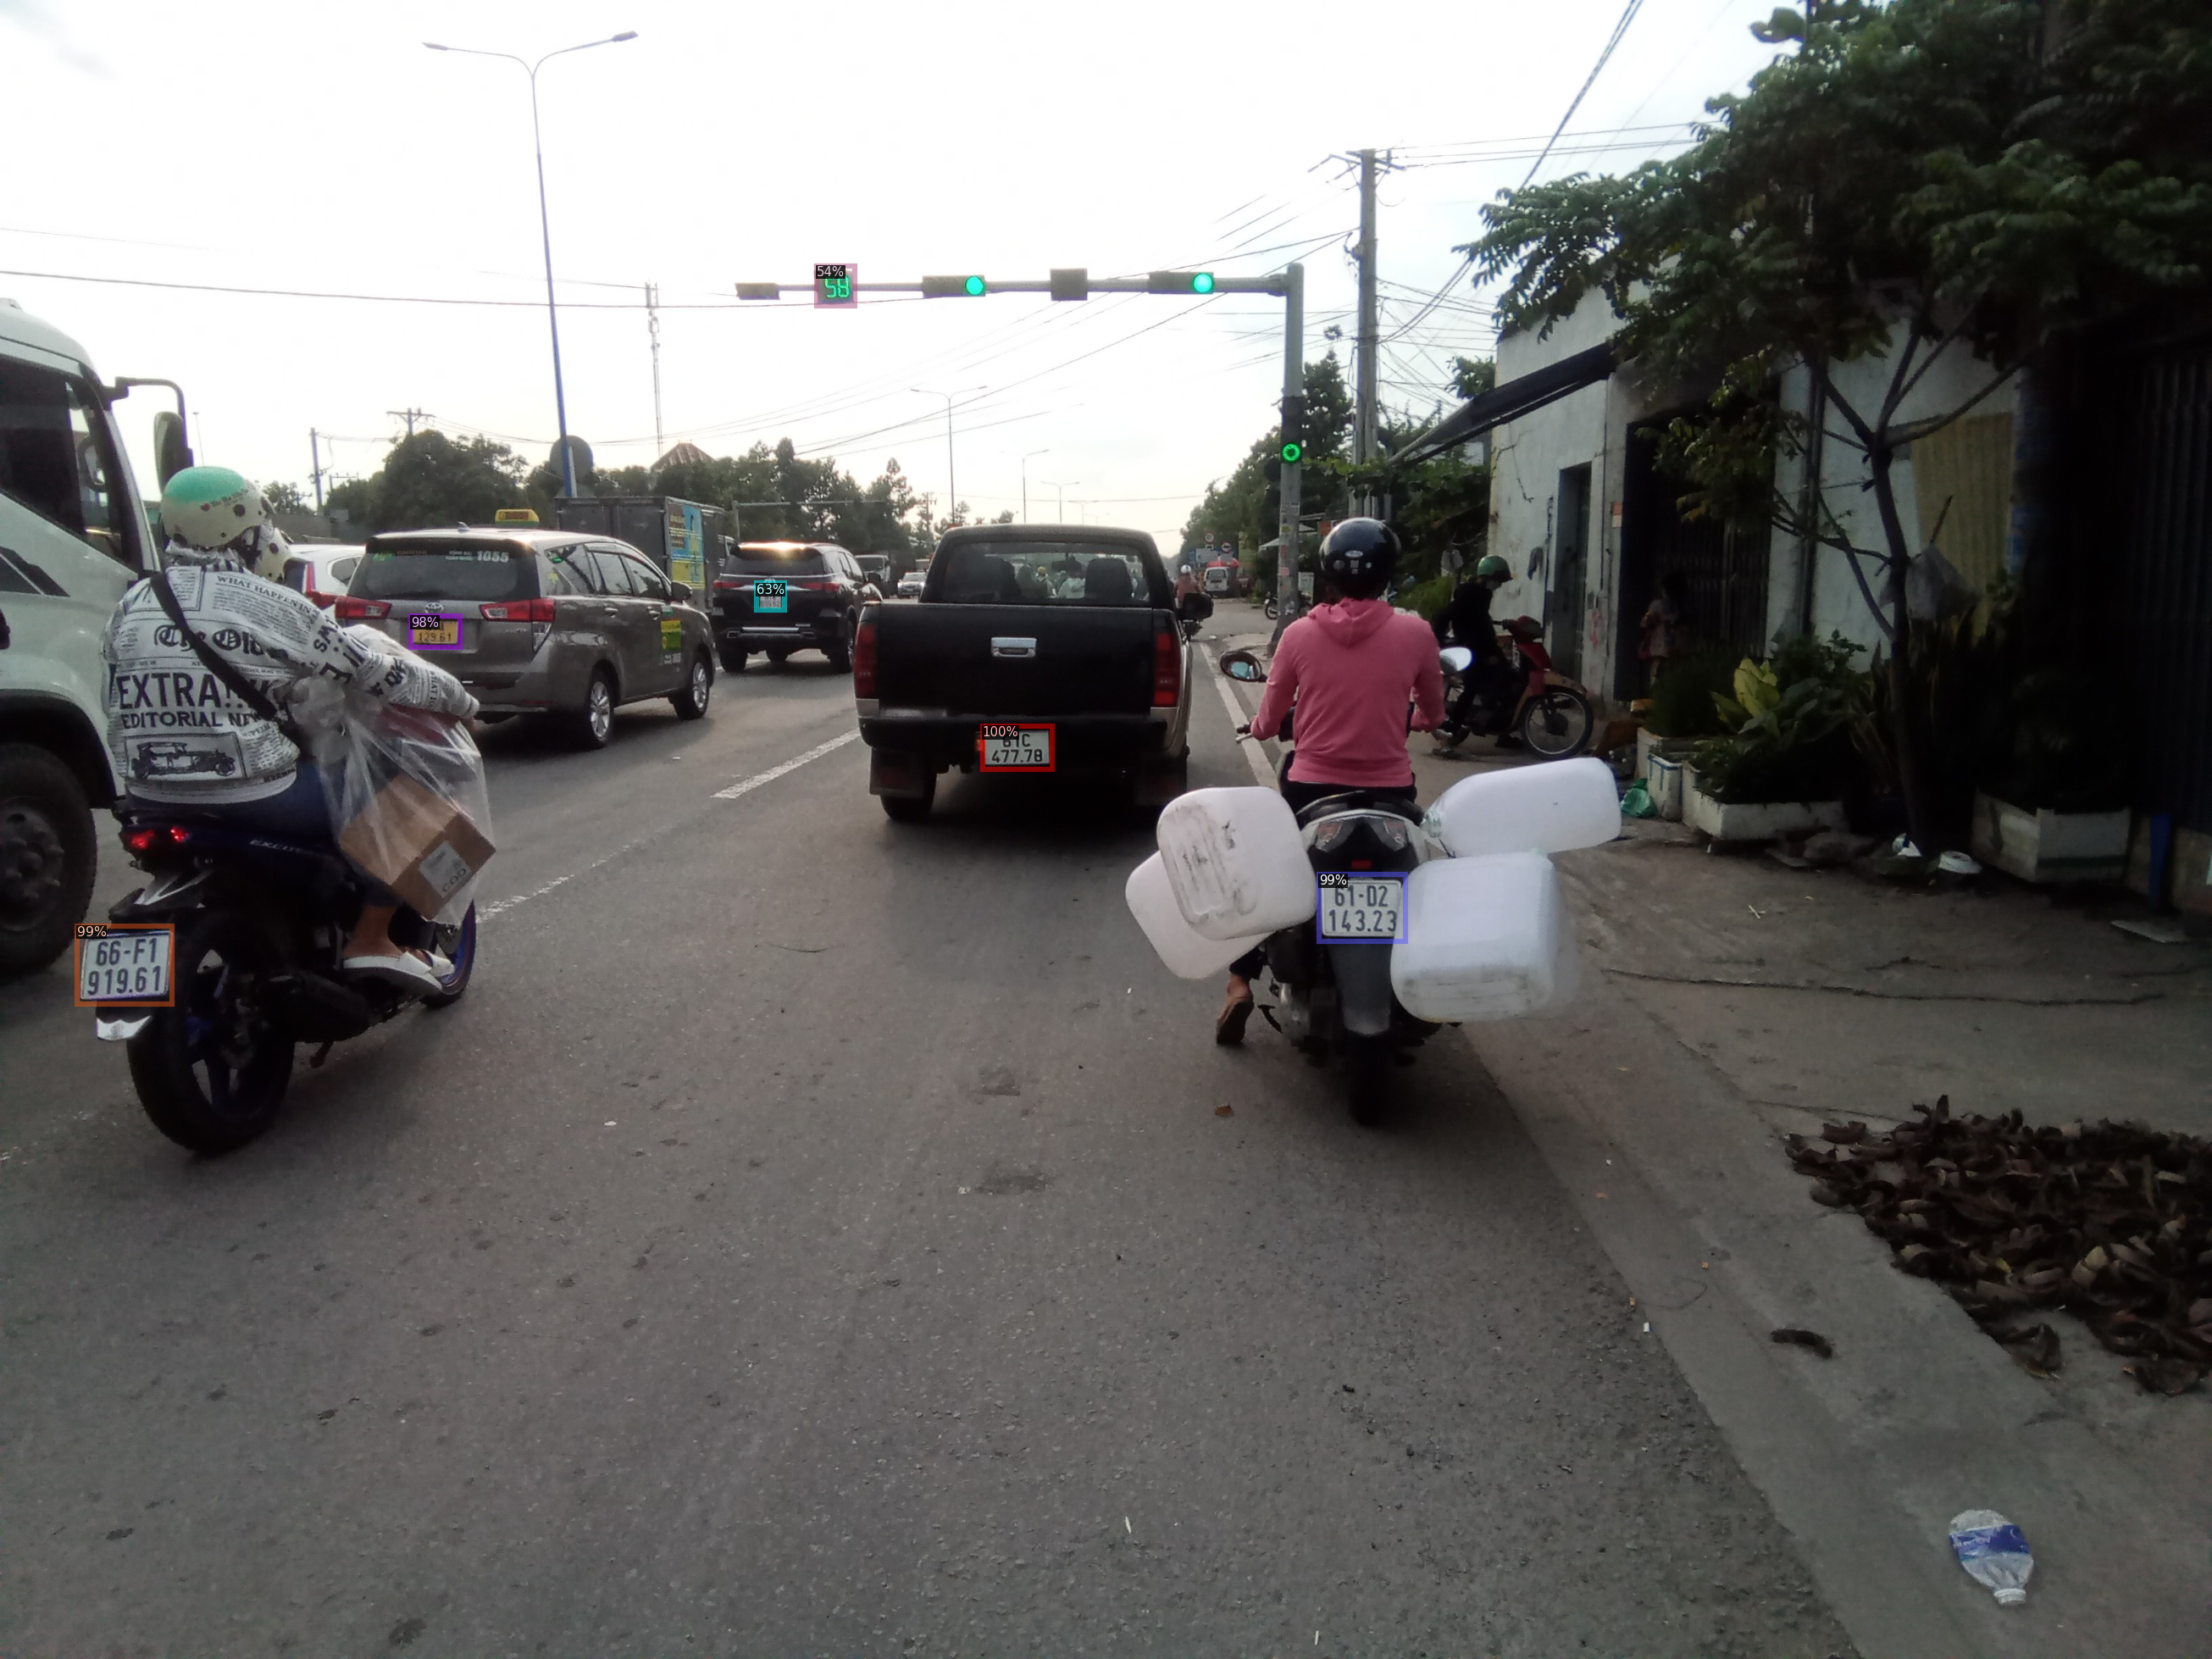

In [13]:
#Detect trên ảnh 
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
# Get the training dataset
cfg.DATASETS.TRAIN = ("dataset_train")

# Use GPU to train
cfg.MODEL.DEVICE = 'cuda'

# Number of classes + 1
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 

# Output dir to load model
cfg.OUTPUT_DIR = "/content/drive/MyDrive/detectron/output3"

# Load weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# Set thresh
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.25   # set the testing threshold for this model



predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("/content/train/_annotations.coco.json")


# Read image and detect
im = cv2.imread('/content/drive/MyDrive/DatasetCS114/test/IMG_20220609_162144_233.jpg')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
            metadata=test_metadata, 
            scale=0.8
                )

# Draw bounding box and plot image
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

#Detect on Video


In [21]:
#Clone code từ trên github về để detect trên tập video test từ repos facebookresearch/detectron2 
%cd /content/drive/MyDrive/detectron
!git clone https://github.com/facebookresearch/detectron2

/content/drive/MyDrive/detectron
Cloning into 'detectron2'...
remote: Enumerating objects: 14407, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 14407 (delta 5), reused 7 (delta 2), pack-reused 14392
Receiving objects: 100% (14407/14407), 5.90 MiB | 6.23 MiB/s, done.
Resolving deltas: 100% (10417/10417), done.
Checking out files: 100% (814/814), done.


In [14]:
#"Đăng ký" datasets cho video trong tập test cần được detect
%cd /content/drive/MyDrive/detectron/detectron2/detectron2
register_coco_instances("dataset_test21", {}, "/content/train/_annotations.coco.json", "/content/drive/MyDrive/detectron/testing_Trim.mp4")


/content/drive/MyDrive/detectron/detectron2/detectron2


In [ ]:
%cd /content/drive/MyDrive/detectron/detectron2
%run demo/demo.py --config-file /content/detectron2/configs/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml --video-input /content/drive/MyDrive/detectron/testing_Trim.mp4 --confidence-threshold 0.6 --output /content/drive/MyDrive/video.mkv --opts MODEL.WEIGHTS /content/drive/MyDrive/detectron/output3/model_final.pth
